# Vendée Globe 2020-2021


1. Vitesse moyenne des voiliers
2. Cartes de la course
3. Impact du foil sur différents paramètres


&copy; 2024 Francis Wolinski

In [17]:
import pandas as pd

df = (pd
      .read_csv("vg_2020.zip")
      .assign(date=lambda df_: pd.to_datetime(df_.date))
     )

## 1. Vitesse moyenne des voiliers

On calcule la vitesse moyenne de l'ensemble des voiliers par degré de longitude et de latitude.

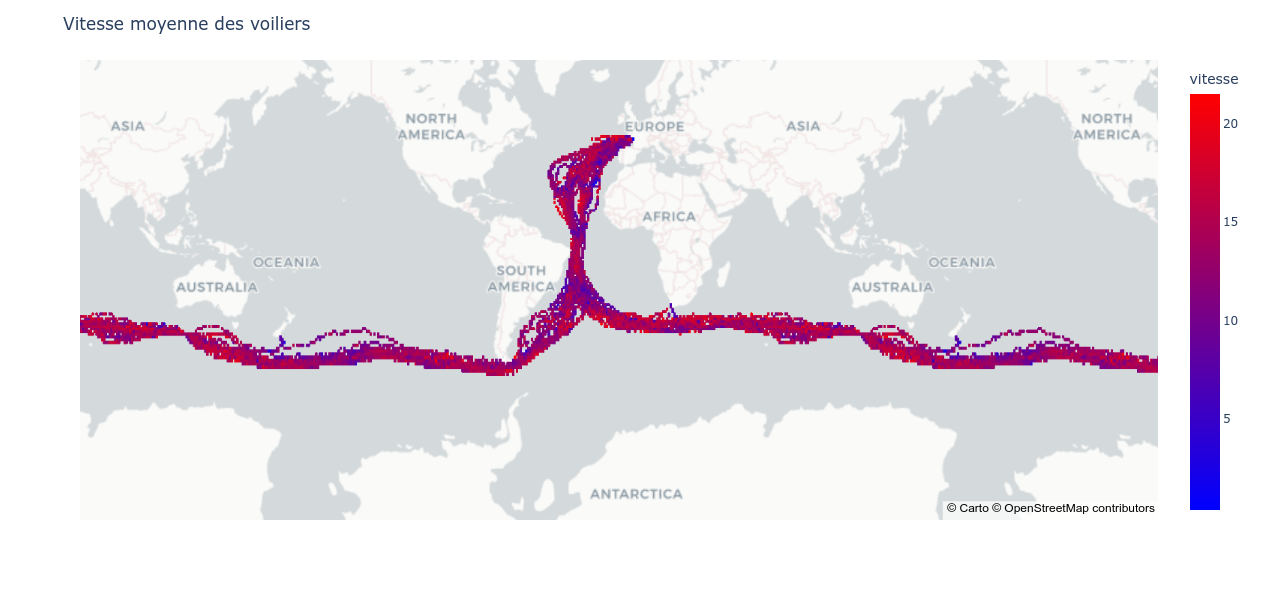

In [24]:
import numpy as np
import plotly.express as px

# Display the average speed by degrees of latitude and longitude
def show_speed(df):
    """Display the average speed by degrees of latitude and longitude"""

    # Display of positions
    def longlat2id(long, lat):
        we = 'W' if long < 0 else 'E'
        sn = 'S' if lat < 0 else 'N'
        return f"{abs(lat)}° {sn}, {abs(long)}° {we}"

    # Build a geojson data structure adapted to the current race for choropleth graph
    def make_feature(long, lat):
        d = dict(type="Feature",
                 properties=dict(position=longlat2id(long, lat)),
                 geometry=dict(type="Polygon", coordinates=[[[long,lat],[long+1,lat],[long+1,lat+1],[long,lat+1],[long,lat]]]))
        return d

    # Compute the average speed by degrees of latitude and longitude
    tab = df[['latitude', 'longitude', 'vitesse_last']].copy()
    tab[['latitude', 'longitude']] = np.floor(tab[['latitude', 'longitude']]).astype(int)

    pivot = (tab
             .pivot_table(index='latitude',
                          columns='longitude',
                          values='vitesse_last')
            )

    tab = pivot.stack().dropna().round(1).reset_index().rename(columns={0:"vitesse"})
    tab["position"] = tab["longitude"].combine(tab["latitude"], longlat2id)

    longs_lats = tab[["longitude", "latitude"]].drop_duplicates().values

    geojson = dict(type="FeatureCollection",
                 features=[make_feature(long, lat) for long, lat in longs_lats])

    fig = px.choropleth_mapbox(data_frame=tab,
                                    geojson=geojson,
                                    locations='position',
                                    color="vitesse",
                                    featureidkey='properties.position',
                                    color_continuous_scale="Bluered",
                                    mapbox_style="carto-positron",
                                    height=600,
                                    width=800,
                                    center={'lat':tab["latitude"].mean(), 'lon':tab["longitude"].mean()},
                                    zoom=0.4)
    fig.update_traces(marker_line_width=0)
    fig.update_layout(title=dict(text="Vitesse moyenne des voiliers"))
    return fig

show_speed(df)

## 2. Cartes de la course

On affiche 3 cartes de la course pour les 11 premiers, les 11 suivants et ainsi de suite.

In [19]:
# data prep
def get_skippers(df, start, stop):
    """Retrieve all skippers"""

    skippers = (df[['date', 'skipper', 'DTF']]
                .sort_values('date')
                .drop_duplicates(subset='skipper', keep='last')
                .sort_values('DTF')
                .iloc[start:stop]
                .loc[:, 'skipper']
                .values
               )

    return skippers

# map of skippers
def show_globe(df, start, stop, projection='orthographic'):
    """Display a map with the skippers ranked from start to stop"""

    dt = df['date'].max().strftime('%d/%m/%Y %Hh')

    skippers = get_skippers(df, start, stop)

    df2 = (df
           .loc[lambda df_: df_.skipper.isin(skippers)]
           .sort_values(['DTF', 'date'])
           .astype({"rang": str})
           )

    last_skippers = df2.groupby('skipper')['date'].max()
    ret_skippers = last_skippers.loc[last_skippers != df2['date'].max()].index
    df2.loc[df2.skipper.isin(ret_skippers), "rang"] = "abandon"

    fig = px.line_geo(df2, lat='latitude', lon='longitude', hover_name="skipper",
                        hover_data={'skipper': False, 'voilier': True, 'rang': True},
                        color='skipper', projection=projection)

    fig.update_geos(
        projection=dict(rotation=dict(lat=df2['latitude'].iloc[0], lon=df2['longitude'].iloc[0])))

    fig.update_layout(showlegend = True,
                        height=500,
                        title_text = f'Vendée Globe au {dt}<br />rang {start+1} - {stop}',
                        geo = dict(
                            showland = True,
                            showcountries = True,
                            showocean = True,
                            countrywidth = 0.5,
                            landcolor = 'tan',
                            lakecolor = 'aliceblue',
                            oceancolor = 'aliceblue',
                            lonaxis = dict(
                                showgrid = True,
                                gridcolor = 'rgb(102, 102, 102)',
                                gridwidth = 0.5),
                            lataxis = dict(
                                showgrid = True,
                                gridcolor = 'rgb(102, 102, 102)',
                                gridwidth = 0.5)))

    fig.update_layout(
        hoverlabel=dict(
            bgcolor="white",
            font_size=16,
            font_family="Rockwell"
        )
    )

    return fig

In [20]:
show_globe(df, 0, 11)

In [21]:
show_globe(df, 11, 22)

In [22]:
show_globe(df, 22, 33)

## 3. Impact du foil sur différents paramètres

On calcule l'impact du foil sur différents paramètres et présenté soit dans le temps soit selon la distance à l'arrivée.

In [23]:
# compute foil impact on numeric columns
import numpy as np
from pandas.api.types import is_numeric_dtype
import plotly.graph_objects as go
import ipywidgets as widgets

def impact_foil_on_column(col, aggfunc, scale, df):

    # cas où col = scale = DTF => pas de graphique
    if col == scale == 'DTF':
        print('pas de graphique')
        return None

    # selection et tri
    tab = df[[scale, 'foil', col]].copy().sort_values(scale)
    tab['foil'] = tab['foil'].map({0:'sans', 1:'avec'})

    # DTF arrondies aux centaines pour calculer les moyennes
    if scale == 'DTF':
        tab[scale] = tab[scale].apply(lambda x: round(x, -2))

    # 1. groupby
    tab = tab.groupby([scale, 'foil'])
    # 2. aggfunc
    if aggfunc == 'count':
        tab = tab.count()
    elif aggfunc == 'mean':
        tab = tab.mean()
    elif aggfunc == 'std':
        tab = tab.std()
    elif aggfunc == 'min':
        tab = tab.min()
    elif aggfunc == '25%':
        tab = tab.quantile(.25)
    elif aggfunc == '50%':
        tab = tab.median()
    elif aggfunc == '75%':
        tab = tab.quantile(.75)
    elif aggfunc == 'max':
        tab = tab.max()
    else:
        raise (f'Unknown aggfunc: {aggfunc}')
    # 3. reshape
    tab = tab.unstack().droplevel(0, axis=1)
    tab["flag"] = tab['avec'] >= tab['sans']
    tab["change"] = (tab["flag"] != tab["flag"].shift()) | (tab['avec'].isna() != tab["avec"].shift().isna()) | (tab['sans'].isna() != tab["sans"].shift().isna())
    l = list(tab.index)
    pos = [l.index(i) for i in tab.loc[tab["change"]==True].index]
    dfs = [tab.iloc[pos[i]:pos[i+1]+1] for i in range(len(pos)-1)]
    fig = go.Figure()
    color1, color2 = px.colors.qualitative.Plotly[:2]

    sans_flag = True
    avec_flag = True

    for group in dfs:
        if group["avec"].iloc[:-1].isna().all():
            fig.add_traces(go.Scatter(x=group.index, y=group['sans'],
                                      line=dict(color=color2),
                                      name="sans foil",
                                      showlegend=sans_flag,
                                      mode='lines'))
            sans_flag = False
            
        elif group["sans"].iloc[:-1].isna().all():
            fig.add_traces(go.Scatter(x=group.index, y=group['avec'],
                                      line=dict(color=color1),
                                      name="avec foil",
                                      showlegend=avec_flag,
                                      mode='lines'))
            avec_flag = False

        elif (group["flag"].iloc[:-1] == True).all():
            fig.add_traces(go.Scatter(x=group.index, y=group['avec'],
                                      line=dict(color=color1),
                                      name="avec foil",
                                      showlegend=avec_flag,
                                      mode='lines'))
            fig.add_traces(go.Scatter(x=group.index, y=group['sans'],
                                      line=dict(color=color2),
                                      fill='tonexty', 
                                      fillcolor=color1,
                                      showlegend=False,
                                      mode='lines'))
            avec_flag = False
        else:
            fig.add_traces(go.Scatter(x=group.index, y=group['sans'],
                                      line=dict(color=color2),
                                      name="sans foil",
                                      showlegend=sans_flag,
                                      mode='lines'))
            fig.add_traces(go.Scatter(x=group.index, y=group['avec'],
                                      line=dict(color=color1),
                                      fill='tonexty', 
                                      fillcolor=color2,
                                      showlegend=False,
                                      mode='lines'))
            sans_flag = False

    return fig


# interaction
def interact(df):
    # colonnes numériques avec variance
    num_cols = [col for col in df.columns if is_numeric_dtype(df[col]) and not np.allclose(df.groupby('skipper')[col].var().dropna(), 0)]

    # dropdown columns
    column = widgets.Dropdown(options=num_cols,
                              value='VMG_24h',
                              description='Colonne :',
                              )
    # dropdown aggfunc
    aggfunc = widgets.Dropdown(options=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'],
                               value='mean',
                               description='Agrégation :'
                               )

    # radio button scale
    scale = widgets.RadioButtons(options=['date', 'DTF'],
                                 value='date',
                                 description='Échelle :'
                                 )

    widgets.interact(impact_foil_on_column, col=column, aggfunc=aggfunc, scale=scale, df=widgets.fixed(df))


interact(df)

interactive(children=(Dropdown(description='Colonne :', index=13, options=('rang', 'latitude', 'longitude', 'c…